In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

In order to analyze sleep data, we want to be able to answer the following questions:
- What are the sleep habits of the fitbit users?
- What are the activity habits of those who sleep the best and the worst?
- Is there an actionable way of improving sleep quality of those who sleep poorly?

In [2]:
path = '../Fitabase Data 4.12.16-5.12.16'
paths_list = [os.path.join(path, f) for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))]
dataframes = {}
for i, f in enumerate(os.listdir(path)):
    dataframes[f.split('.')[0]] = pd.read_csv(paths_list[i])
dataframes.keys()

dict_keys(['minuteIntensitiesWide_merged', 'dailyActivity_merged', 'sleepDay_merged', 'heartrate_seconds_merged', 'minuteIntensitiesNarrow_merged', 'minuteMETsNarrow_merged', 'hourlySteps_merged', 'hourlyIntensities_merged', 'dailyCalories_merged', 'hourlyCalories_merged', 'minuteSleep_merged', 'minuteCaloriesNarrow_merged', 'dailySteps_merged', 'minuteCaloriesWide_merged', 'minuteStepsNarrow_merged', 'minuteStepsWide_merged', 'weightLogInfo_merged', 'dailyIntensities_merged'])

In [3]:
sns.set_style("darkgrid")

## What are the sleep habits of the fitbit users?

In order to better understand sleep habits of fitbit users we will divide them in 4 groups:
- Excess > 9 hours 
- Good 7 - 9 hours
- Deprived < 7

https://www.sleepfoundation.org/how-sleep-works/how-much-sleep-do-we-really-need#:~:text=National%20Sleep%20Foundation%20guidelines1,to%208%20hours%20per%20night


In [4]:
sleepDay = dataframes['sleepDay_merged']
sleepDay['hours'] = sleepDay['TotalMinutesAsleep'] / 60

In [5]:
bins = [sleepDay.hours.min(), 7, 9, sleepDay.hours.max()]

labels = ['deprived', 'good', 'excess']

sleepDay['SleepBins'] = pd.cut(
    sleepDay['hours'],
    bins=bins,
    labels=labels,
    include_lowest=True,
    right=False,
)

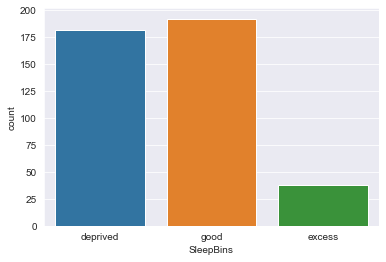

In [6]:
sns.countplot(data=sleepDay, x = 'SleepBins');

From our binning we can see that the amount of people which have the reccomended amount of sleep is very similar to the amount of people which are sleep deprived, on the other hand, excess sleep seems to be less common.

One would not expect the same amount of sleep deprived people as those who get enough sleep. Therefore we will verify if there are any outliers. 

### Outliers

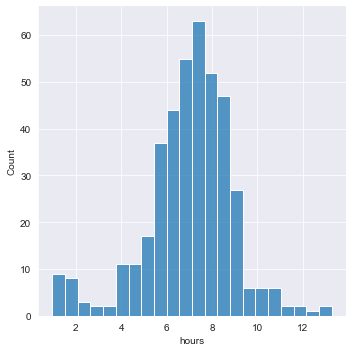

In [7]:
sns.displot(data=sleepDay, x='hours');

- It appears that we have a peak of records which indicate 3 or less hours of sleep. This is unusual in what looks like an otherwise normal distribution. 

- For the next steps we will exclude those which have less than 3 hours of sleep, so we will be looking at "normal" values. 

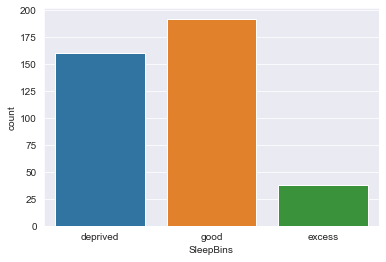

In [8]:
sleepDay = sleepDay[sleepDay['hours'] > 3].copy()
sns.countplot(data=sleepDay, x = 'SleepBins');

### Collecting the IDs of those which sleep the best

- in order to find those with the best sleep habits, we need to see how many nights with enough sleep they have over all the recorded nights. 
- we will perform some grouping and then pivot the resultin table to gather the required data

In [9]:
sleepPivot = sleepDay.groupby(
    ['Id',
     'SleepBins']).agg(sleepCount=('SleepBins', 'count')).reset_index().pivot(
         index='Id', columns='SleepBins',
         values='sleepCount')
sleepPivot['goodRatio'] = sleepPivot['good'] / sleepPivot[['deprived', 'good', 'excess']].sum(axis=1)

sleepEnhanced = sleepDay.merge(sleepPivot, on = 'Id')
sleepEnhanced['goodSleeper'] = sleepEnhanced['goodRatio'] >= 0.6

In [10]:
sleepEnhanced.drop_duplicates(subset=['Id']).goodSleeper.value_counts()

False    16
True      5
Name: goodSleeper, dtype: int64

---
This concludes our first part of the analysis. 
We were able to:
- bin users based on the amount of sleep recorded
- detect and exclude outliers with extremely low times of sleep
- find IDs of the users which get enough sleep the most

The last step will allow us to further analyze the data at our disposal

## What are the activity habits of those who sleep the best and the worst?
- we will start our analyses by merging the previously obtained dataset with `dailyActivity_merged`

### Activity correlation

In [11]:
sleepEnhanced['Date'] = pd.to_datetime(sleepEnhanced['SleepDay']).dt.date
dailyActivity = dataframes['dailyActivity_merged']
dailyActivity['Date'] = pd.to_datetime(dailyActivity['ActivityDate']).dt.date
dailyActivity['ActiveMinutes'] = dailyActivity[[
    'VeryActiveMinutes', 'FairlyActiveMinutes', 'LightlyActiveMinutes'
]].sum(axis=1)

In [12]:
sleepEnhanced = sleepEnhanced.merge(
    dataframes['dailyActivity_merged'],
    on=['Id', 'Date'],
)
sleepEnhanced = sleepEnhanced[[
    'Id', 'Date', 'TotalMinutesAsleep', 'TotalTimeInBed', 'hours', 'SleepBins',
    'goodSleeper', 'TotalSteps', 'TotalDistance', 'ActiveMinutes',
    'SedentaryMinutes', 'Calories'
]]

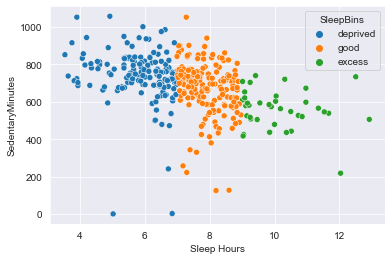

In [13]:
sns.scatterplot(data=sleepEnhanced, x = 'hours', y = 'SedentaryMinutes', hue='SleepBins')
plt.xlabel("Sleep Hours");

It appears that the amount of sedentary minutes has some correlation with the amount of hours slept. 

In fact, those which tend to be very sedentary also sleep the least, while those which sleep more than 9 hours are also those which tend to be the least sedentary.

In order to deepen our findings, we will add another dataset which enhances the current one with heart rate data: `heartrate_seconds_merged`

In [14]:
heartData = dataframes['heartrate_seconds_merged']
heartData['Datetime'] = pd.to_datetime(heartData['Time'], format="%m/%d/%Y %I:%M:%S %p")
heartData = heartData[heartData.Id.isin(sleepEnhanced.Id)].copy()
heartData['Hour'] = heartData['Datetime'].dt.hour + (heartData['Datetime'].dt.minute / 60)
heartData['Date'] = heartData['Datetime'].dt.date

In [15]:
bins = [0, 5, 12, 17, 21, 24]

labels = ['night', 'morning', 'day', 'afternoon', 'evening']

heartData['TimeBins'] = pd.cut(
    heartData['Hour'],
    bins=bins,
    labels=labels,
    include_lowest=True,
    right=True,
)

In [16]:
heartData['binMedian'] = heartData.groupby(['Id', 'Date', 'TimeBins'])['Value'].transform('median')
heartData = heartData[['Id', 'Date', 'TimeBins', 'binMedian']].drop_duplicates()
sleepEnhanced = sleepEnhanced.merge(heartData, on = ['Id', 'Date'])

In [17]:
sleepEnhanced

,Id,Date,TotalMinutesAsleep,TotalTimeInBed,hours,SleepBins,goodSleeper,TotalSteps,TotalDistance,ActiveMinutes,SedentaryMinutes,Calories,TimeBins,binMedian
0,2026352035,2016-04-17,437,498,7.283333,good,True,838,0.52,60,1053,1214,morning,68.0
1,2026352035,2016-04-25,506,531,8.433333,good,True,6017,3.73,260,821,1576,morning,98.0
2,2026352035,2016-05-02,511,543,8.516667,good,True,7018,4.35,355,716,1690,afternoon,81.0
3,2026352035,2016-05-02,511,543,8.516667,good,True,7018,4.35,355,716,1690,evening,73.0
4,2026352035,2016-05-09,531,556,8.850000,good,True,10685,6.62,401,543,1869,day,105.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
791,8792009665,2016-05-03,516,545,8.600000,good,False,2421,1.55,156,739,2297,day,76.0
792,8792009665,2016-05-03,516,545,8.600000,good,False,2421,1.55,156,739,2297,afternoon,86.0
793,8792009665,2016-05-03,516,545,8.600000,good,False,2421,1.55,156,739,2297,evening,78.0
794,8792009665,2016-05-04,439,463,7.316667,good,False,2283,1.46,129,848,2067,night,74.0


When grouping hear rates, we took the median value for the hour, as sudden bursts of activity, like using the stairs or inacurracies of the sensor might affect our value

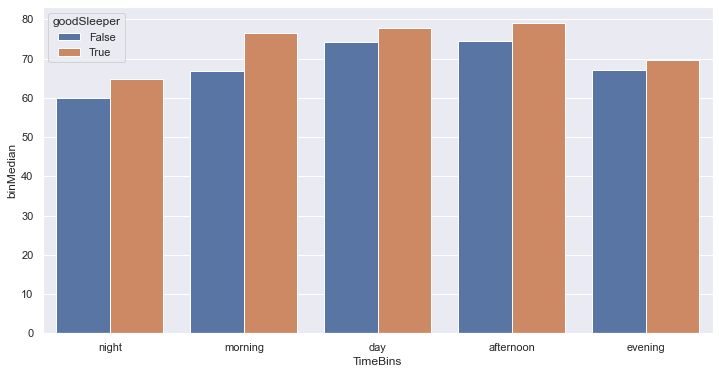

In [47]:
sns.barplot(data=sleepEnhanced,
            x='TimeBins',
            y='binMedian',
            hue='goodSleeper',
            ci=None);

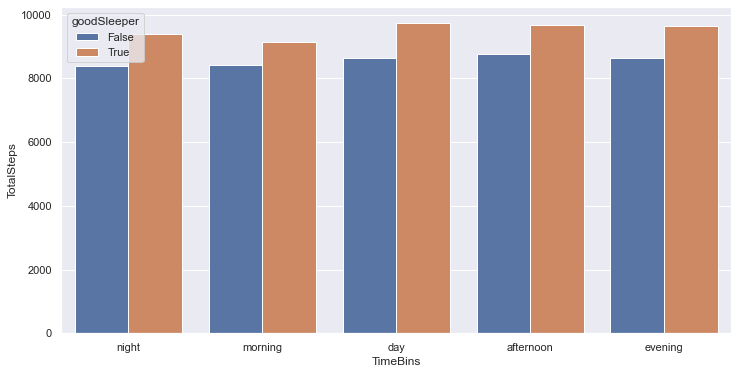

In [49]:
sns.barplot(data=sleepEnhanced,
            x='TimeBins',
            y='TotalSteps',
            hue='goodSleeper',
            ci=None);

It appears that the median heart rate of good sleepers is higher in every time section of the day

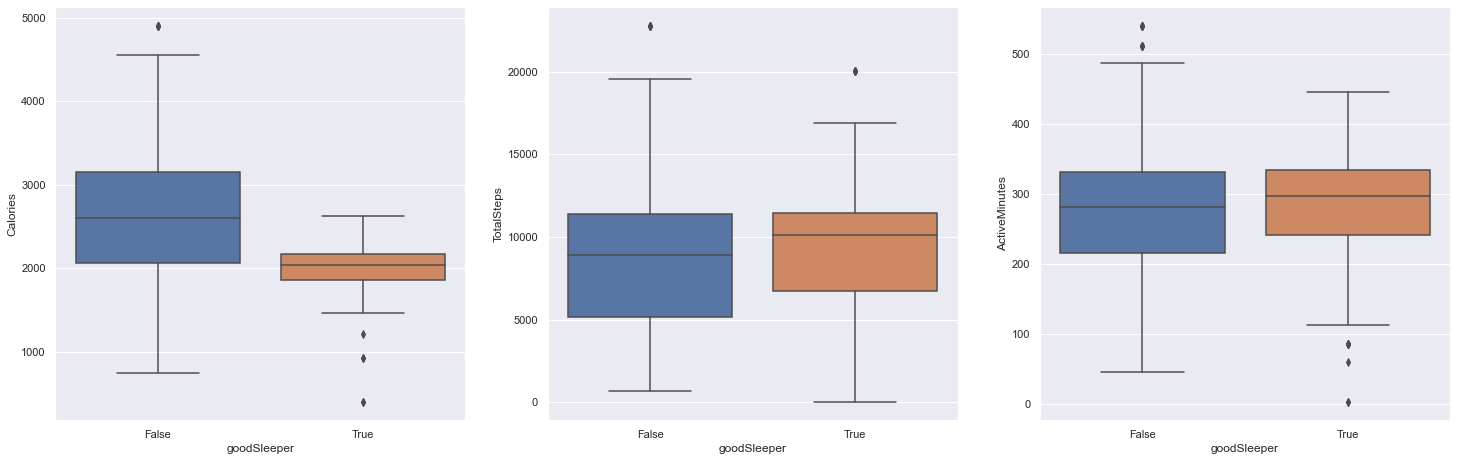

In [77]:
sns.set(rc={'figure.figsize': (12, 6)})
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(25, 7.6))
sns.boxplot(data=sleepEnhanced,
            x='goodSleeper',
            y='Calories',
            ax=ax1);

sns.boxplot(data=sleepEnhanced,
            x='goodSleeper',
            y='TotalSteps',
            ax=ax2);

sns.boxplot(data=sleepEnhanced,
            x='goodSleeper',
            y='ActiveMinutes',
            ax=ax3);

The three graphs above are able to show some interesting information about the data (in order from left to right):
1. On average good sleepers burn much less calories than the opposite side
2. On average good sleepers walk a little more and the interquartile range is more packed
3. Good sleepers are more active on average, and again the iqr is more packed. In both good and bad sleepers there are outliers in opposite directions, and good sleepers have tighter min-max values

The findings are interestin as they show that those which sleep better do not burn more calories than those who sleep badly. In fact plot 2, 3 show that they are more active but it is shown in plot 1 that the activity must be at a lower intensity. 

## Is there an actionable way of improving sleep quality of those who sleep poorly?

after analyzing the data from the fitbit users it appears that those which do not have good sleeping habits or are experiencing bad sleep should perform lower intensity activities which allow to be active longer. Moreover these activities should be at an intensity level which allows to sustain it for longer without consuming too much energy, thus reducing the burned calories. 